In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import skorch
import numpy as np

from torch.autograd import Variable

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from torch.utils.data import DataLoader, TensorDataset
from sine_data import train_dataset, valid_dataset

In [28]:
class DiffPlast(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', foo=1, rule='oja', learn_lr=False, lr=1e-4):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.i2h = nn.Linear(input_dim, hidden_dim)
        self.hebb = nn.Parameter(torch.zeros(hidden_dim, hidden_dim))
        self.alpha = nn.Parameter(torch.zeros(hidden_dim))
        
        if learn_lr:
            self.lr = nn.Parameter(torch.tensor(lr))
        else:
            self.lr = lr
        self.foo = foo
        self.rule = rule
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
        self.reset_weights()
        
    def reset_weights(self):
        torch.nn.init.xavier_normal_(self.i2h.weight)
        self.i2h.bias.data.zero_()
        torch.nn.init.normal_(self.hebb, 0, 0.01)
        torch.nn.init.uniform_(self.alpha, 0, 1)
        
    def compute_hebbian(self, x, y, hebb):
        if self.rule == 'oja':
            #return hebb + self.lr * y * (x - (y.unsqueeze(-1) * hebb))
            return hebb + self.lr * y.unsqueeze(-1) * (x.unsqueeze(-1) - (y.unsqueeze(-1) * hebb))
        elif self.rule == 'hebb':
            return self.lr * (x.unsqueeze(-1) * y.unsqueeze(1)) + (1 - self.lr) * hebb
        raise ValueError

    def initial_hebbian(self, x):
        return torch.zeros(x.size(0), self.hidden_dim, self.hidden_dim).to(x)
        
    def forward(self, x): # x is (b, t, u) 
        H = self.initial_hebbian(x)
        i2h = self.i2h(x.view(-1, self.input_dim)).to(x)
        i2h = i2h.view(x.size(0), x.size(1), self.hidden_dim)
        ys = []
                
        for ti in range(x.size(1)):
            # compute neuron
            y = i2h[:, ti] + self.alpha * torch.bmm(x[:, ti:ti+1], H).squeeze(1) * self.foo
            y = self.act(y)

            # update hebbian trace
            H = self.compute_hebbian(x[:, ti], y, H)
                        
            ys.append(y)
        
        return torch.stack(ys, dim=1), H

In [29]:
import visdom
vis = visdom.Visdom()

In [30]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [31]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [32]:
class ReconModel(nn.Module):
    def __init__(
        self, num_hidden=64, act='tanh', visdom=False, rule='hebb', foo=1, learn_lr=False, lr=1e-4, num_layers=1
    ):
        super().__init__()
        
        self.rnn = []
        self.num_layers = num_layers
        self.visdom = visdom
        
        self.i2h = nn.Linear(1, num_hidden)
        
        for i in range(num_layers):
            self.rnn.append(DiffPlast(num_hidden, num_hidden, act=act, foo=foo, rule=rule, learn_lr=learn_lr, lr=lr))
            self.add_module('rnn'+str(i), self.rnn[-1])
        
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        li = self.i2h(x)
        for i in range(self.num_layers):
            li, hi = self.rnn[i](li)
            if self.visdom:
                vis.heatmap(skorch.utils.to_numpy(li[0]), opts={'title': 'act rnn'+str(i)}, win="act rnn"+str(i))
        l1 = self.clf(time_flatten(li))
        return time_unflatten(l1, x.size())

In [33]:
class Trainer(skorch.NeuralNet):
    def __init__(
        self, 
        criterion=nn.MSELoss,
        *args, 
        **kwargs
    ):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, training=training)

In [52]:
torch.manual_seed(1337)

def my_train_split(ds, y):
    return ds, skorch.dataset.Dataset(X_valid[:, :-1], X_valid[:, 1:])

ef = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.02,
             max_epochs=40,
             train_split=my_train_split,
             
             module__visdom=False,
             module__num_hidden=16,
             module__act='tanh',
             module__num_layers=1,
             module__rule='oja',
             module__lr=0.01,
             module__foo=1,
             module__learn_lr=False,
             
             device='cuda',
             batch_size=2,
            )

In [53]:
%pdb on
ef.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.4855        0.7066  0.4745
      2        0.7508        0.7868  0.4450
      3        0.6384        0.5203  0.4606
      4        0.3241        0.2480  0.4411
      5        0.4182        0.3155  0.4430
      6        0.1974        0.1898  0.4406
      7        0.1198        0.1298  0.4472
      8        0.1290        0.1211  0.4699
      9        0.1095        0.1814  0.4876
     10        0.1031        0.2611  0.4463
     11        0.1129        0.1740  0.4514
     12        0.0880        0.1187  0.4743
     13        0.0780        0.1201  0.4578
     14        0.0663        0.1413  0.4491
     15        0.0663        0.1235  0.5073
     16        0.0595        0.0785  0.4998
     17        0.0479        0.0601  0.4549
     18        0.0401        0.0575  0.4527
     19        0.0346        0.0566  0.4807
     20        0.0319        0.0442

<class '__main__.Trainer'>[initialized](
  module_=ReconModel(
    (i2h): Linear(in_features=1, out_features=16, bias=True)
    (rnn0): DiffPlast(
      (i2h): Linear(in_features=16, out_features=16, bias=True)
      (act): Tanh()
    )
    (clf): Linear(in_features=16, out_features=1, bias=True)
  ),
)

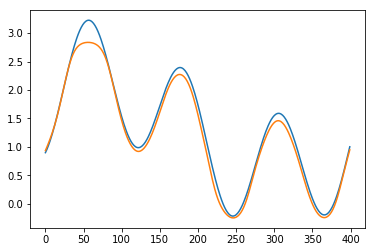

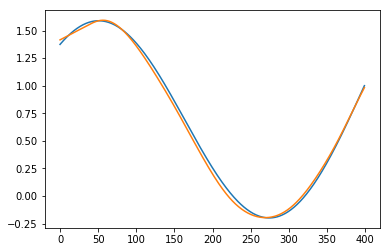

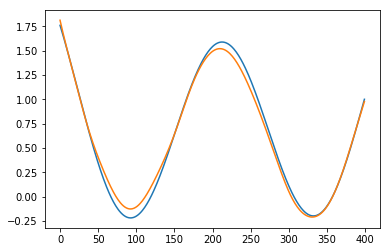

In [54]:
data = X_valid
pred = ef.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])